<a href="https://colab.research.google.com/github/mikaelangelm/object-detection/blob/main/yolov3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
# !pip3 install opencv-python

In [42]:
#https://github.com/pjreddie/darknet
#https://pjreddie.com/darknet/yolo/
from IPython.display import Image#, Video
import matplotlib.pyplot as plt
import time
from IPython import display
from PIL import ImageFont, Image, ImageDraw, ImageFont
import cv2
import numpy as np
img_name_in = 'img_in.jpg'
img_name_out = 'img_out.jpg'
img = 0
video_name_in = 'https://sirius-online.ru/6500c9aa-bbf8-4fb1-a39c-84c1124c6e25'#'http://109.236.111.203/mjpg/video.mjpg' #'video_in.mp4'
video_name_out = 'video_out.mp4'
recognize = True

try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    path = '/content/drive/MyDrive/Colab Notebooks/YOLO_project/'
except:
    path = ''

Mounted at /content/drive


In [43]:
# yolov3.cfg     - https://drive.google.com/file/d/1x--1Sr_retPaqtspgt-KrJuIIrcRjwHS/view?usp=sharing 
# yolov3.weights - https://drive.google.com/file/d/1-7VuI0LA_k_9e7F2c2K4gl61lPCbDBn3/view?usp=sharing
net = cv2.dnn.readNet(path + 'yolov3.cfg', path + 'yolov3.weights')

layer_names = net.getLayerNames()
out_layers_indexes = net.getUnconnectedOutLayers()
out_layers = [layer_names[index[0] - 1] for index in out_layers_indexes]

with open(path + 'coco.names.txt') as f:
    classes = f.read().split('\n')

In [44]:
def apply_yolo(img):
    height,width,depth = img.shape
    blob = cv2.dnn.blobFromImage(img, 1/255, (608,608), (0,0,0), swapRB=True, crop=False)
    net.setInput(blob)
    
    outs = net.forward(out_layers)
    
    boxes = []
    class_indexes = []
    class_scores = []

    for out in outs:
        for obj in out:
            #print(obj)
            scores = obj[5:]
            class_index = np.argmax(scores)
            class_score = scores[class_index]
            if class_score > 0: 
                #print(class_index, class_score)
                center_x = int(obj[0] * width)
                center_y = int(obj[1] * height)
                obj_width = int(obj[2] * width)
                obj_height = int(obj[3] * height)

                x = center_x - obj_width // 2
                y = center_y - obj_height // 2

                box = [x,y,obj_width,obj_height]
                boxes.append(box)
                class_indexes.append(class_index)
                class_scores.append(float(class_score))
                
    chosen_boxes = cv2.dnn.NMSBoxes(boxes, class_scores, 0, 0.35)
    #print(chosen_boxes)
    
    for box_index in chosen_boxes:
        #print(index[0])
        box_index = box_index[0]
        img = draw_object(img, class_indexes[box_index], class_scores[box_index], boxes[box_index])
        
    return img


In [45]:
def draw_object(img, index, score, box):
    x,y,w,h = box
    start = (x,y)
    end = (x + w, y + h)
    color = (0,255,0)
    width = 1
    
    img = cv2.rectangle(img, start, end, color, width)
    
    start = (x-10, y-10)
    font_size = 1
    font = cv2.FONT_HERSHEY_SIMPLEX
    width = 1
    text = classes[index]
    
    img = cv2.putText(img, text, start, font, font_size, color, width, cv2.LINE_AA)
    # TODO play with fonts
#     font = ImageFont.truetype('segoeuil.ttf', size=18)
#     img = ImageDraw.Draw(img)
#     img.text(
#         start,
#         text,
#         # Добавляем шрифт к изображению
#         font=font,
#         fill='#00FF00')
    
    return img

In [46]:
#@title Photo from google.colab 
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

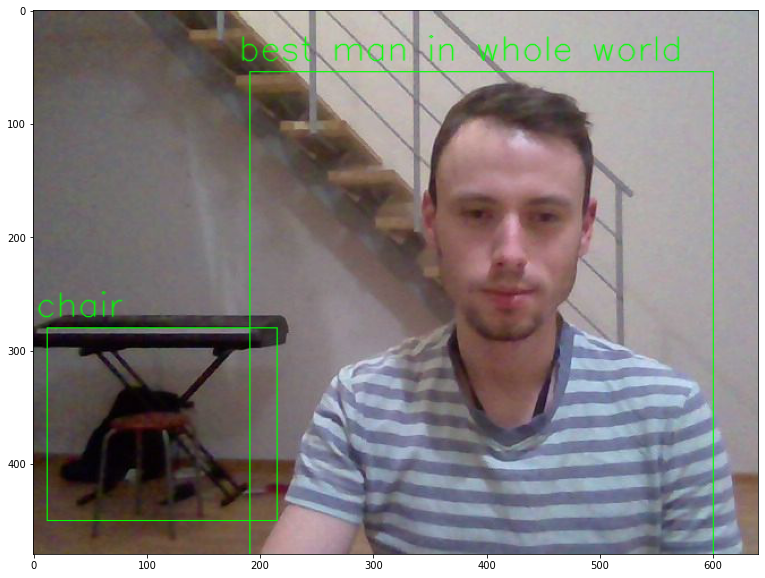

In [54]:
GET_PHOTO_NOT_VIDEO_IN = True # для просмотра фото/видео - Показать диспетчер файлов (Ctrl + M + H)

try:
    # снять фото на камеру ноутбука и записать в диспетчер файлов под именем photo.jpg
    if GET_PHOTO_NOT_VIDEO_IN:
        cap     = take_photo() # cv2.VideoCapture(0) # 0 # video_name_in # 
        frame   = np.array(Image.open(cap))
        frame   = apply_yolo(frame) 
        # change color and resize
        # frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # frame = cv2.resize(frame, size)
        plt.figure(figsize=(20,10))
        plt.imshow(frame)
        do_break = True

    # детектировать объекты на первых 60 фреймах видео video_name_in и записать в диспетчер файлов под именем video_name_out
    else:
        size = (1280, 720)
        video_name_in   = 'https://vod-progressive.akamaized.net/exp=1644618882~acl=%2Fvimeo-prod-skyfire-std-us%2F01%2F1863%2F17%2F434316667%2F1891638771.mp4~hmac=1e8ec81349d05536d13cc369e53fa6a48c3b33b5c4e4bdb6fa55656774836a5f/vimeo-prod-skyfire-std-us/01/1863/17/434316667/1891638771.mp4?download=1&filename=Market+-+42932.mp4'#'http://109.236.111.203/mjpg/video.mjpg' #'video_in.mp4'
        video_name_out  = '/video_out.mp4'
        codec           = cv2.VideoWriter_fourcc('H','2','6','4') #'H','2','6','4' #*'mp4v' #*'MJPG' #*'XVID'
        out             = cv2.VideoWriter(video_name_out, apiPreference=0, fourcc=codec, fps=29, frameSize=size)        
        
        cap = cv2.VideoCapture(video_name_in)
        n_frames = 1
        while(cap.isOpened()) and n_frames >= 0:
            ret, frame = cap.read()
            n_frames -= 1
            if not ret:
                break
                
            frame = apply_yolo(frame)
            # изменение размера
            # frame = cv2.resize(frame, size)       
            # сохранение кадра 
            out.write(frame)
        cap.release()
        out.release()
        
        if path.find('content/drive') > 0:
            from google.colab import files
            files.download(video_name_out) 
    

except KeyboardInterrupt:
    print('Something went wrong')

try:
    cap.release()
except:
    pass

cv2.destroyAllWindows()



In [48]:
# from IPython.display import HTML
# from base64 import b64encode

# mp4 = open(video_name_out, "rb").read()
# data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
# HTML(f"""
# <video width=400 controls>
#       <source src="{data_url}" type="video/mp4">
# </video>
# """)